# Demonstration of the instability of likelihood-based training

In [29]:
%matplotlib inline

import numpy as np
from scipy.stats import norm
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import plot_settings as ps


In [30]:
ps.setup()

## "Training data"

In [31]:
n = 1000
x = np.vstack((np.zeros(n), np.random.normal(size=n))).T

## Model

In [32]:
def model(x, alpha, std):
    # Rotation matrix
    c, s = np.cos(alpha), np.sin(alpha)
    r = np.matrix([[c, s], [-s, s]])
    
    # Encode to latent space
    u, v = np.einsum("ij,ni->jn", r, x)
    
    # Density in latent space
    log_prob = np.mean(norm(loc=0, scale=std).logpdf(u))
    
    # Decode onto manifold
    uv_reco = np.vstack((u, np.zeros_like(v))).T
    x_reco = np.einsum("ji,ni->nj", r, uv_reco)
    
    # Reconstruction error
    delta_x = np.mean(np.sum((x_reco - x)**2, axis=1)**0.5)
    
    return log_prob, delta_x

## Evaluate model over a grid of parameters

In [33]:
res = 100

alpha_range = np.linspace(0., np.pi, res)
std_range = np.linspace(1.e-9, 1.5, res)
alpha_grid, std_grid = np.meshgrid(alpha_range, std_range)
alpha_grid = alpha_grid.flatten()
std_grid = std_grid.flatten()

log_prob_grid, delta_x_grid = [], []
for alpha, std in zip(alpha_grid, std_grid):
    log_prob, delta_x = model(x, alpha, std)
    log_prob_grid.append(log_prob)
    delta_x_grid.append(delta_x)
    
log_prob_grid = np.array(log_prob_grid).reshape(res, res)
delta_x_grid = np.array(delta_x_grid).reshape(res, res)

## Plot setup

In [46]:
alpha = 1.2
unit_vec = np.array([np.cos(alpha), np.sin(alpha)])
unit_vec_3d = [np.cos(alpha), np.sin(alpha), 0.]

pdf_res = 200
extent = 2.8

x_pdf = np.linspace(-4., 4., pdf_res) * np.cos(alpha)
y_pdf = np.linspace(-4., 4., pdf_res) * np.sin(alpha)
z_pdf = norm.pdf(np.linspace(-4., 4., pdf_res))

extent_cut = (x_pdf**2 < extent**2) * (y_pdf**2 < extent**2)
x_pdf = x_pdf[extent_cut]
y_pdf = y_pdf[extent_cut]
z_pdf = z_pdf[extent_cut]

x_pdf = [x_pdf[0]] + list(x_pdf) + [x_pdf[-1]]
y_pdf = [y_pdf[0]] + list(y_pdf) + [y_pdf[-1]]
z_pdf = [0] + list(z_pdf) + [0]

r_std = 1.
x_std = r_std * np.cos(alpha)
y_std = r_std * np.sin(alpha)
z_std = norm.pdf(r_std)


In [47]:
def add_transparancy(color, alpha):
    color2 = np.copy(np.array(color))
    if len(color2.shape) == 1:
        if color2.shape[0] == 4:
            color2[3] = alpha
            return color2
        elif color2.shape[0] == 3:
            return np.hstack((color2, [alpha]))
        
    else:
        if color2.shape[1] == 4:
            color2[:,3] = alpha
            return color2
        elif color2.shape[1] == 3:
            return np.hstack((color2, alpha*np.ones((color2.shape[0], 1))))
    

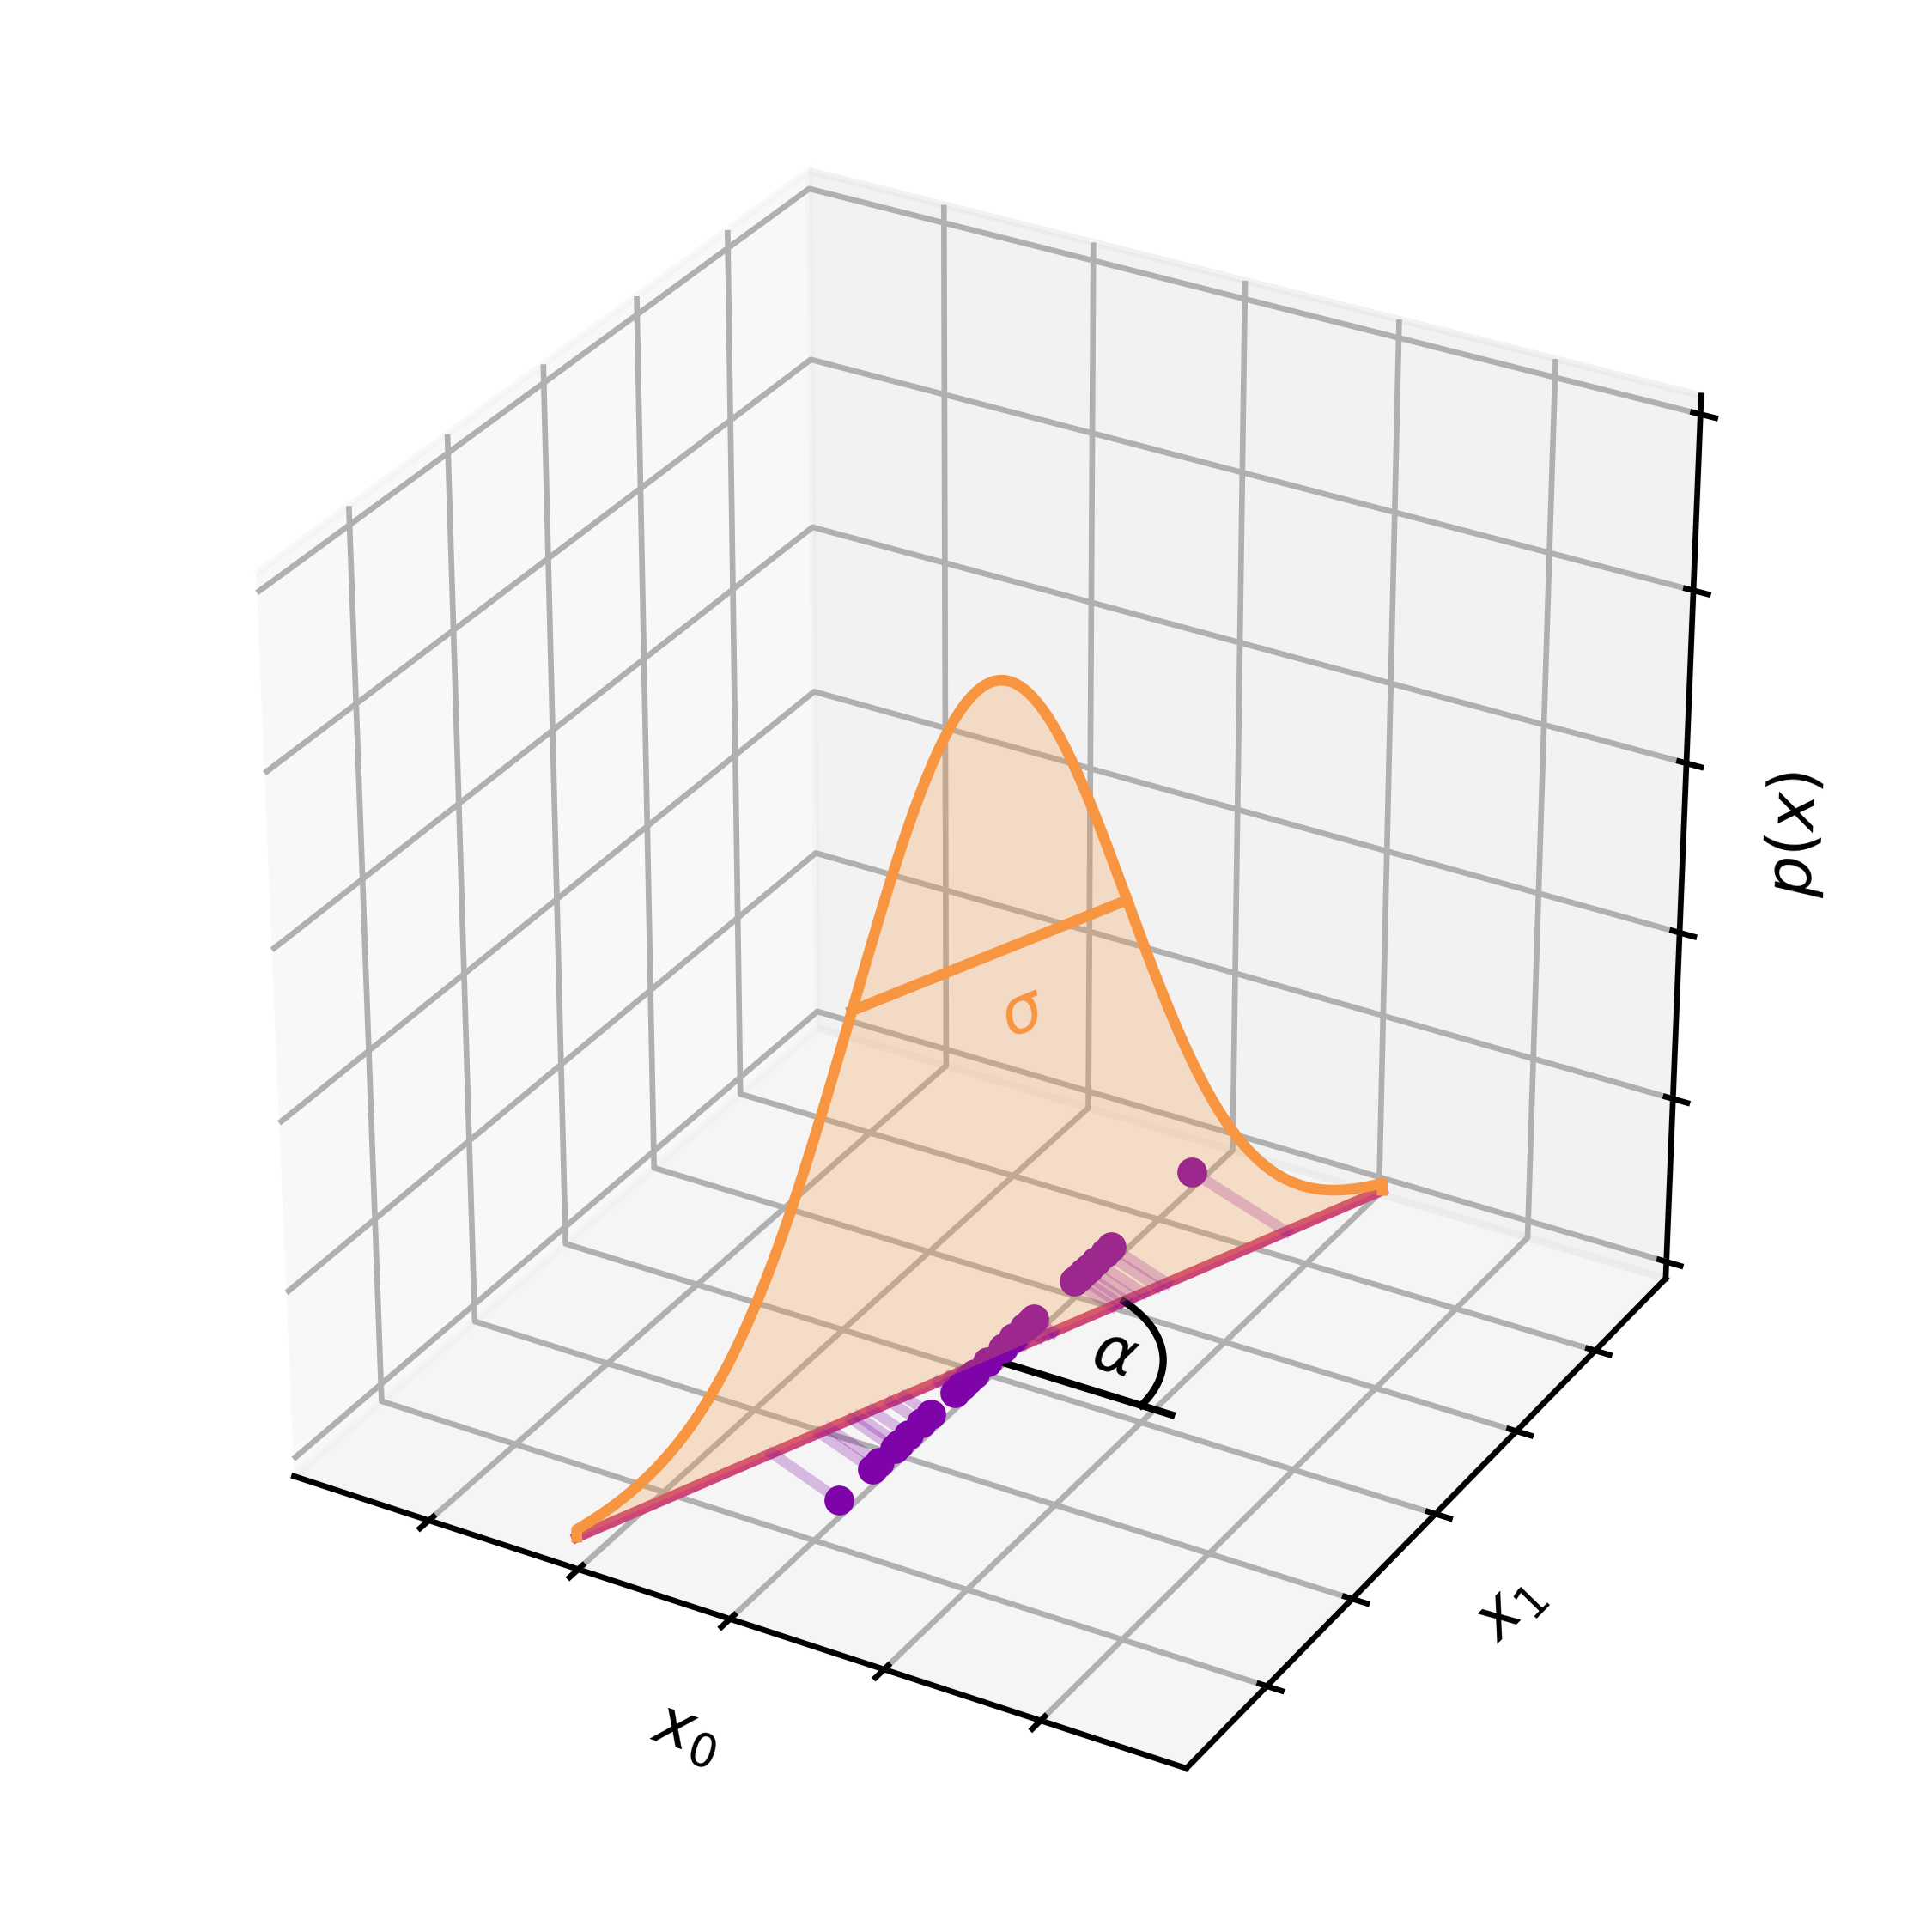

In [60]:
n_data = 30

fig, ax = ps.figure(cbar=False, make3d=True, large_margin=0.2, small_margin=0.2)

# PDF
vertices = [list(zip(x_pdf, y_pdf, z_pdf))]
poly = Poly3DCollection(
    vertices,
    facecolors=[add_transparancy(ps.COLORS[3], alpha=0.25)],
    #edgecolors=[add_transparancy(ps.COLORS[3], alpha=0.25)]
)
ax.add_collection3d(poly, zdir='z')
ax.plot(x_pdf, y_pdf, z_pdf, c=ps.COLORS[3], zorder=4.)

# Manifold
ax.plot(x_pdf, y_pdf, np.zeros_like(z_pdf), c=ps.COLORS[2])

# Label sigma
ax.plot([-x_std, x_std], [-y_std, y_std], [z_std, z_std], c=ps.COLORS[3])
ax.text(0.,0.,0.8*z_std,r"$\sigma$", unit_vec_3d, c=ps.COLORS[3])

# Label alpha
ax.plot([0, 1.2], [0, 0], [0,0], c=ps.COLOR_NEUTRAL1, lw=1.)
angles=np.linspace(0, alpha, 100)
ax.plot(np.cos(angles), np.sin(angles), np.zeros_like(angles), c=ps.COLOR_NEUTRAL1, lw=1.)
ax.text(0.6, 0.4, 0, r"$\alpha$", "x", c=ps.COLOR_NEUTRAL1, fontsize=9, ha="center", va="center")

# Data

# Data projection
for x_ in x[:n_data]:
    if x_[0]**2 < extent**2 and x_[1]**2 < extent**2:
        ax.scatter([x_[0]], [x_[1]], [0.], alpha=1., s=10., c=[ps.COLORS[1]])
        proj = [unit_vec.dot(x_) * np.cos(alpha), unit_vec.dot(x_) * np.sin(alpha)]
        ax.plot([x_[0], proj[0]], [x_[1], proj[1]], np.zeros(2), c=add_transparancy(ps.COLORS[1], 0.25))
        #ax.scatter([proj[0]], [proj[1]], [0.], alpha=0.25, s=8., c=[ps.COLORS[1]])

# Axis ranges and view
ax.set_xlim3d(-extent, extent)
ax.set_ylim3d(-extent, extent)
ax.set_zlim3d(0., .5)
# ax.view_init(30, -40)

# Labels
ax.set_xlabel("$x_0$", labelpad=-10.)
ax.set_ylabel("$x_1$", labelpad=-10.)
ax.set_zlabel(r"$p(x)$", labelpad=-10.)
ax.set_xticklabels([""]*5)
ax.set_yticklabels([""]*5)
ax.set_zticklabels([""]*5)

plt.savefig("../figures/instability_demo_setup.pdf")


## 2D plot setup

In [ ]:
fig, ax = ps.figure()

plt.plot([0, 1.2], [0, 0], c=ps.COLOR_NEUTRAL2, lw=1.)
angles=np.linspace(0,np.arctan(8./5.), 100)
plt.plot(np.cos(angles), np.sin(angles), c=ps.COLOR_NEUTRAL2, lw=1.)
plt.text(0.6, 0.4, r"$\alpha$", c=ps.COLOR_NEUTRAL2, fontsize=12, ha="center", va="center")
plt.scatter(x[:50,0], x[:50,1], s=20., c=ps.COLORS[1], label="Training data")
plt.plot([-5, 5], [-8, 8], c=ps.COLORS[3], lw=2., label=r"Manifold")
plt.plot([], [], c="white", ls=" ", label=r"  (Gaussian density, std $\sigma$)")
plt.legend(loc="lower right")
ax.axis("equal")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")

plt.show()
#plt.savefig("../figures/instability_demo_setup.pdf")


## Plot result

In [ ]:
label_kwargs={"ha":"left", "va":"top", "x":0.1, "y":1.43, "c":"white", "fontsize":9., "fontweight":"500"}

fig, gs = ps.grid(2, 2)

ax = plt.subplot(gs[0])
zmin, zmax = -5., 1.
im = plt.imshow(
    np.clip(log_prob_grid, zmin, zmax),
    extent=(0., np.pi, 1.e-6, 1.5),
    origin="lower",
    cmap=ps.CMAP,
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest',
    aspect="auto"
)
plt.scatter([0.5*np.pi],[1.], marker="*", s=30., c=ps.COLOR_NEUTRAL1)
plt.text(s="Log likelihood", **label_kwargs)
plt.xlim(0., np.pi)
plt.ylim(1.e-6, 1.5)
plt.ylabel(r"$\sigma$")
ax.get_xaxis().set_visible(False)

ax = plt.subplot(gs[1])
zmin, zmax = 0.,0.8
im = plt.imshow(
    np.clip(delta_x_grid, zmin, zmax),
    extent=(0., np.pi, 1.e-6, 1.5),
    origin="lower",
    cmap=ps.CMAP_R,
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest',
    aspect="auto"
)
plt.scatter([0.5*np.pi],[1.], marker="*", s=30., c=ps.COLOR_NEUTRAL1)
plt.text(s="Reco error", **label_kwargs)
plt.xlim(0., np.pi)
plt.ylim(1.e-6, 1.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(gs[2])
zmin, zmax = 0.2,1.2
im = plt.imshow(
    np.clip(delta_x_grid - 0.3 * log_prob_grid, zmin, zmax),
    extent=(0., np.pi, 1.e-6, 1.5),
    origin="lower",
    cmap=ps.CMAP_R,
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest',
    aspect="auto"
)
plt.scatter([0.5*np.pi],[1.], marker="*", s=30., c=ps.COLOR_NEUTRAL1)
plt.text(s="Combined loss", **label_kwargs)
plt.xlim(0., np.pi)
plt.ylim(1.e-6, 1.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\sigma$")

ax = plt.subplot(gs[3])
zmin, zmax = -0.2, 0.
im = plt.imshow(
    np.clip(log_prob_grid - np.max(log_prob_grid, axis=0)[np.newaxis, :], zmin, zmax),
    extent=(0., np.pi, 1.e-6, 1.5),
    origin="lower",
    cmap=ps.CMAP,
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest',
    aspect="auto"
)
plt.scatter([0.5*np.pi],[1.], marker="*", s=30., c=ps.COLOR_NEUTRAL1)
plt.text(s="Log p relative to \n" + r"MLE for each $\alpha$", **label_kwargs)
plt.xlim(0., np.pi)
plt.ylim(1.e-6, 1.5)
plt.xlabel(r"$\alpha$")
ax.get_yaxis().set_visible(False)

plt.savefig("../figures/instability_demo_losses.pdf", dpi=600.)

In [ ]:
ps.COLORS

In [ ]:
np.array(ps.COLORS[3])*256.